In [2]:
#load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
#load dataset
df_train = pd.read_csv("reddit_200k_train.csv",encoding='latin1')
df_test = pd.read_csv("reddit_200k_test.csv",encoding='latin1')

In [4]:
#get the text and traget for train, test dataset
text_train=df_train['body']
y_train=df_train['REMOVED']
text_test=df_test['body']
y_test=df_test['REMOVED']


In [5]:
# Basic info for test dataset
print("type of text_train: ", type(text_train))
print("length of text_train: ", len(text_train))
print("class balance: ", np.bincount(y_train))

type of text_train:  <class 'pandas.core.series.Series'>
length of text_train:  167529
class balance:  [102791  64738]


According to the output above, the training set is imbalanced with one class has nearly twice data samples than the other.

## Task1 Bag of Words and simple Features

### 1.1 Create a baseline model using a bag-of-words approach and a linear model

In [75]:
for text in text_train[:10]:
    print (text)

I've always been taught it emerged from the earth after an impace. That is why it has similar elemental distribution to earth
As an ECE, my first feeling as "HEY THAT'S NOT-" and then I thought about all the times my co-workers couldn't even write a simple message in our communication book without making mistakes. 

I'm getting out of the profession. 
Monday: Drug companies stock dives on good news for patients.
i learned that all hybrids are unfertile i wont read clickbaits https://biology.stackexchange.com/questions/16922/why-are-hybrids-infertile
Well i was wanting to get wasted tonight.  Not so much after reading this article...
So when we can remember a history where he shared a [certain dinner](http://www.huffingtonpost.co.uk/2012/07/02/stephen-hawking-time-travel_n_1643488.html) with Stephen Hawking we'll know it worked.
Keep going! So close to a 100% run.
Rains here just start, no buildup.. one or two summer storms get a couple days of the air being electric, but that's it
That

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object
vect = CountVectorizer(stop_words='english')
# learn thr vocabularies and transform the train,test dataset
X_train = vect.fit_transform(text_train)
X_test = vect.transform(text_test)

In [76]:
print("The shape of the words vetors is:",X_test.shape)

The shape of the words vetors is: (55843, 113494)


In [9]:
from sklearn.linear_model import LogisticRegressionCV

# use logistic regression as the baseline model for the classification
lr = LogisticRegressionCV().fit(X_train, y_train)
print('The accuracy score on test dataset is %.4f'%lr.score(X_train,y_train))

The accuracy score on test dataset is 0.7257


In [10]:
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

def plot_measurement(y_test, y_predict):
    '''
    Function plot_measurement used to plot confusion matrix, roc, and precision-recall curve
    paras:
        y_test: the test target value (array-like)
        y-predict: the predicted target value (array-like)
    return:
        accuracy: prediction accuracy
        average precision: prediction average precision
        f_score: prediction f1 measurement score 
    '''
    #accuracy
    accuracy = metrics.accuracy_score(y_test, y_predict)
    print("The accuracy score on test dataset is %.4f" % accuracy)
    #precision
    precision = metrics.precision_score(y_test, y_predict)
    print('The precision score on test dataset is %.4f' %precision)
    # F-measure
    f1_score = metrics.f1_score(y_test, y_predict)
    print ("The F1-measure score on test dataset is %.4f" % f1_score)

    
    fig = plt.figure(figsize=(15,5))

    # Plot 1: heatmap for confusion matrix
    cm = metrics.confusion_matrix(y_test, y_predict)
    cm_heatmap = fig.add_subplot(1, 3, 1)
    cm_heatmap = sns.heatmap(cm, cmap="PuBu",annot=True, fmt="d")
    cm_heatmap.set_ylabel("Real value")
    cm_heatmap.set_xlabel("Predicted value")
    cm_heatmap.set_title('Confusion Matrix')
    
    # Plot 2: roc and auc
    roc = fig.add_subplot(1, 3, 2)
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict)
    roc_auc = metrics.auc(fpr, tpr)#auc
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)'% roc_auc)
    roc.plot([0, 1], [0, 1], color='navy', linestyle='--')
    roc.set_xlim([0.0, 1.0])
    roc.set_ylim([0.0, 1.0])
    roc.set_xlabel('False Positive Rate')
    roc.set_ylabel('True Positive Rate')
    roc.set_title('Receiver Operating Characteristic')
    _ = plt.legend(loc="lower right")
    
    # Plot 3: Precision_recall curve
    prc = fig.add_subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_predict)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    prc.step(recall, precision, color='b', alpha=0.2,
         where='post')
    prc.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    prc.set_xlabel('Recall')
    prc.set_ylabel('Precision')
    prc.set_ylim([0.0, 1.05])
    prc.set_xlim([0.0, 1.0])
    prc.set_title('Precision-Recall curve')
    
    plt.tight_layout()
    plt.show()
    
    #return accuracy, precision, f1_score
    
    

The accuracy score on test dataset is 0.6924
The precision score on test dataset is 0.6224
The F1-measure score on test dataset is 0.5483


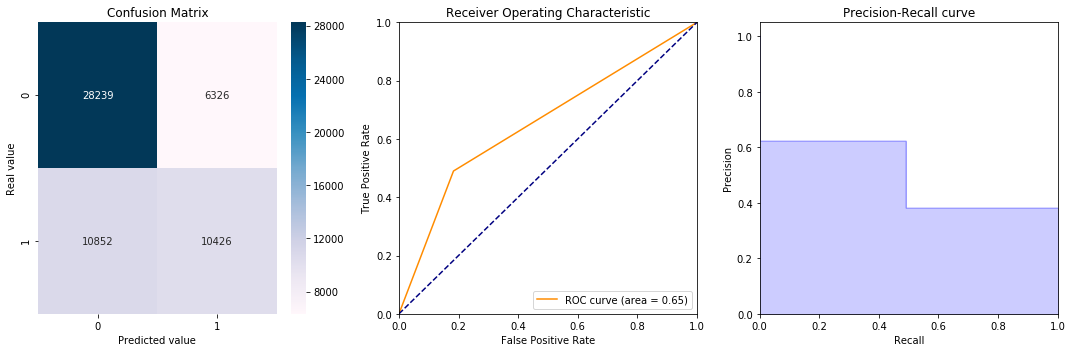

(0.692387586626793,
 array([0.38103254, 0.62237345, 1.        ]),
 0.5483039705495661)

In [11]:
# predict for test dataset
y_pred=lr.predict(X_test)
# evaluate the classification result
plot_measurement(y_test, y_pred)

### 1.2 Tune Bag of Words Model with different approaches

This section tries using **n-grams**, **characters**, **tf-idf** rescaling and other ways to tune the Bags of Words model for the better classification performance.

#### 1.2.1 tokenizer

In the baseline model, we tokenized the reviews by word boundaries,and considering all characters and numbers. First, let's check the tokens in the corpus:

In [226]:
# check the first, middle, last 50 words in the corpus
print("The first 50 words in the corpus:\n",vect.get_feature_names()[:50],"\n")
print("The middle 50 words in the corpus:\n",vect.get_feature_names()[int(vec_length/2-25):int(vec_length/2+25)],"\n")
print("The last 50 words in the corpus:\n",vect.get_feature_names()[-50:],"\n")
print("Every 2000th words in the corpus:\n",vect.get_feature_names()[::2000])

The first 50 words in the corpus:
 ['ability', 'able', 'abstract', 'access', 'activity', 'actual', 'actually', 'adults', 'age', 'ago', 'air', 'alcohol', 'ama', 'america', 'american', 'amp', 'analysis', 'animal', 'animals', 'anti', 'anxiety', 'area', 'areas', 'aren', 'article', 'articles', 'ask', 'associated', 'autism', 'average', 'away', 'bacteria', 'bad', 'based', 'basically', 'behavior', 'believe', 'best', 'better', 'big', 'bit', 'black', 'blood', 'body', 'brain', 'c', 'called', 'came', 'cancer', 'cannabis'] 

The middle 50 words in the corpus:
 [] 

The last 50 words in the corpus:
 ['today', 'told', 'took', 'traditional', 'treatment', 'true', 'try', 'trying', 'type', 'u', 'understand', 'understanding', 'university', 'use', 'used', 'using', 'usually', 've', 'vs', 'wait', 'want', 'warming', 'wasn', 'water', 'way', 'ways', 'weed', 'week', 'weight', 'went', 'white', 'women', 'won', 'wonder', 'words', 'work', 'worked', 'working', 'works', 'world', 'worse', 'wouldn', 'wow', 'wrong', 'www

In the above output, the corpus containing many **numbers** that does not make sense for the classification, as many of them come from the website links. Also, there are many words are not been split with **"_"**. Thus, we will remove the numbers when performing tokenizer on each sentence with **token_pattern= r"((?<=_)|\b)[a-zA-Z]+(\b|(?=_))"**, which means only tokenize the words in the range of 'a-z' and 'A-Z', with word bounday or '_' before and after.

#### 1.2.2 Minimum document frequency min_df

In [121]:
# check the size of corpus
vec_length = X_test.shape[1]
print("Number of words in the vetors:",vec_length)

Number of words in the vetors: 113494


There are more than 100k tokens in the vector, leading to the very large size of the corpus. To exclude the tokens that has a low frequency in documents, let's get the frequency of each token, and count the number of occurance of these frequencies.

In [72]:
# get the frequncy of each token
count = np.asarray(X_train.sum(axis=0))[0].tolist()
count.sort(reverse=True)
# divide the frequency as 6 groups with fq=1,2,3,4,5,>5, and get their corresponding counts of occurance
total_count = []
for i in range(1,11):
    total_count.append(sum([c==i for c in count]))
total_count.append(len(count)-sum(total_count))

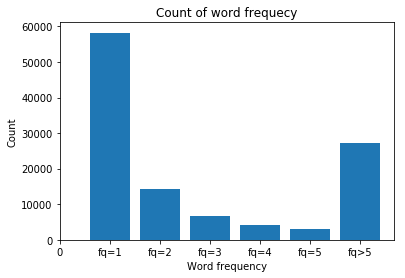

In [120]:
# visulize the frequncy
plt.bar(range(1,12),total_count)
_ = plt.xticks(np.arange(11), ('0','fq=1','fq=2','fq=3','fq=4','fq=5','fq>5'))
_ = plt.title("Count of word frequecy")
_ = plt.xlabel("Word frequency")
_ = plt.ylabel("Count")


From the barchart above, it is observed that more than 50% tokens only have frequency=1. If we set the minimum document frequency (min_df) as 1, we can at least shrink the corpus size by half, Thus, we will GridSearch **min_df as 2 or 3** later.

#### 1.2.3  Approach 1: N-grams and StopWords

For the bags of word approach, we don't consider the sentiment and context of each review, which might affect the performance of the model. Thus, the first approach is applying the **N-grams** when tokenizing. The idea behind N-grams is you look at pairs of words that appear next to each other. As the corpus size will be really great if considering the n-grams, we will use exclude **StopWords** and constraint the corpus size by setting min_df. Also, considering the 

In [198]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

# GridSearch
ngram_param_grid = {
              "countvec__ngram_range": [(1, 1),(1,2)],
              "countvec__min_df": [10,20],
              "norm": [None, Normalizer()]
             }
# build pipelines tokenized, normalize, logisticregression
ngram_pipeline = Pipeline([('countvec', CountVectorizer(stop_words='english',max_features=5000,token_pattern= r"\b[a-zA-Z]+\b")),
                     ('norm', Normalizer()),
                     ('lr',LogisticRegression())])

# = make_pipeline(CountVectorizer(stop_words='english'), LogisticRegression())
ngram_grid = GridSearchCV(ngram_pipeline,param_grid=ngram_param_grid, cv=3)


In [199]:
_=ngram_grid.fit(text_train,y_train)

In [200]:
ngram_grid.best_params_

{'countvec__min_df': 20,
 'countvec__ngram_range': (1, 2),
 'norm': Normalizer(copy=True, norm='l2')}

The accuracy score on test dataset is 0.6909
The precision score on test dataset is 0.6130
The F1-measure score on test dataset is 0.5582


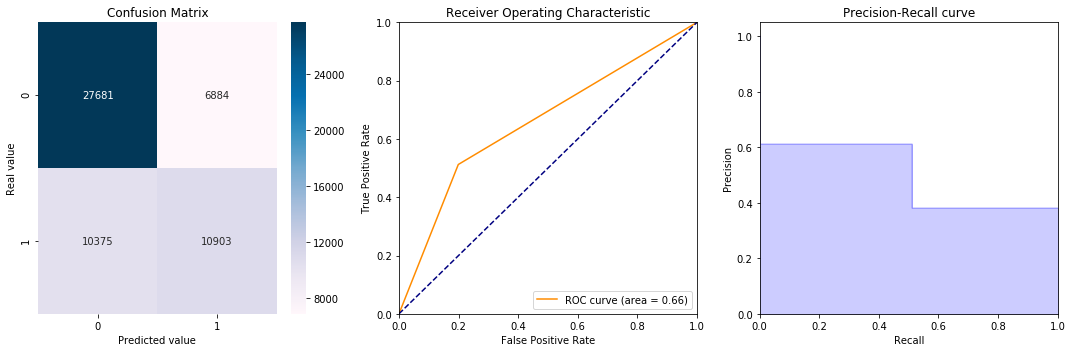

(0.6909370914886378,
 array([0.38103254, 0.61297577, 1.        ]),
 0.5581978753359784)

In [201]:
# predict for test dataset
ngram_pred=ngram_grid.predict(text_test)
# evaluate the classification result
plot_measurement(y_test, ngram_pred)

From the above measurements, we can conclude that even we shrink the max features as 5000, adding StopWords, and exclude numbers from tokens, the performance of the logistic regression model keeps same as the baseline model. However, both the running time and sapce are saved with these constraints, Thus, we will still keep these constraints in the following sections.

#### 1.2.4 Character n-grams

In [203]:
# GridSearch
char_param_grid = {
              "countvec__ngram_range": [(3, 4),(3,5)],
              "norm": [None, Normalizer()],
              "lr__C":[10, 1, 0.1]
             }
# build pipelines tokenized, logisticregression
char_pipeline = Pipeline([('countvec', CountVectorizer(analyzer="char_wb",stop_words='english',max_features=5000,
                                                  token_pattern= r"\b[a-zA-Z]+\b")),
                          ('norm', Normalizer()),
                          ('lr',LogisticRegression())])

char_grid = GridSearchCV(char_pipeline,param_grid=char_param_grid, cv=3)


In [204]:
# fit
_=char_grid.fit(text_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvec', CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
 ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'countvec__ngram_range': [(3, 4), (3, 5)], 'norm': [None, Normalizer(copy=True, norm='l2')], 'lr__C': [10, 1, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [205]:
char_grid.best_params_

{'countvec__ngram_range': (3, 4),
 'lr__C': 10,
 'norm': Normalizer(copy=True, norm='l2')}

The accuracy score on test dataset is 0.7147
The precision score on test dataset is 0.6443
The F1-measure score on test dataset is 0.5998


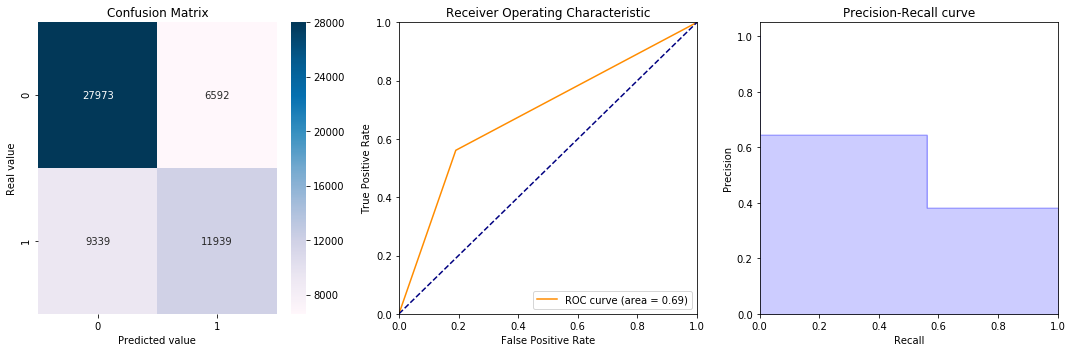

(0.714718048815429,
 array([0.38103254, 0.64427176, 1.        ]),
 0.5998141123866463)

In [207]:
# predict for test dataset
char_grid_pred=char_grid.predict(text_test)
# evaluate the classification result
plot_measurement(y_test, char_grid_pred)

#### 1.2.5 TfidfVectorizer

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer

# GridSearch
tf_param_grid = {
              "tfidfvec__ngram_range": [(1,1),(1,2),(1,3)],
              "lr__C":[10, 1, 0.1]
             }
# build pipelines tokenized, logisticregression
tf_pipeline = Pipeline([('tfidfvec', TfidfVectorizer(stop_words='english',max_features=5000,
                                                  token_pattern= r"\b[a-zA-Z]+\b")),
                       ('lr',LogisticRegression())])

tf_grid = GridSearchCV(tf_pipeline,param_grid=tf_param_grid, cv=3)


In [213]:
# fit
_=tf_grid.fit(text_train,y_train)

In [214]:
tf_grid.best_params_

{'lr__C': 1, 'tfidfvec__ngram_range': (1, 2)}

The accuracy score on test dataset is 0.6896
The precision score on test dataset is 0.6101
The F1-measure score on test dataset is 0.5577


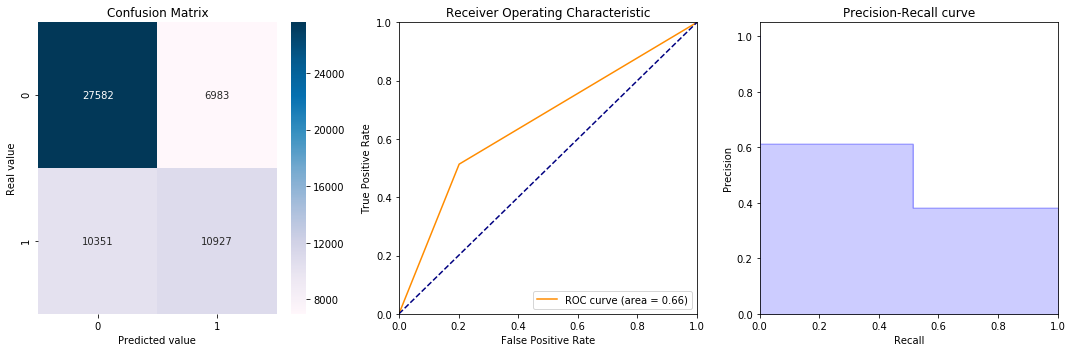

(0.6895940404347904,
 array([0.38103254, 0.61010609, 1.        ]),
 0.5576707155251608)

In [215]:
# predict for test dataset
tf_grid_pred=tf_grid.predict(text_test)
# evaluate the classification result
plot_measurement(y_test, tf_grid_pred)

### 1.3 Explore other features

## Task2 Word Vectors 

This section used a pretrained word-embedding: **word2vec** instead of bag-of-words model to transform each word as a numeric vector. Next, using the average vectors values in each review as the review vector, and applying the LogisticRegression model to classify the sentiment of each review. To measure the perfromance of the classification results, the same metrics are used here.

### 2.1 Data cleaning/text preprocessing

The functions we write to clean the data are also similar to Task 1, although now there are a couple of differences. First, to train Word2Vec it is better not to remove stop words because the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors. For this reason, we will make stop word removal optional in the functions below.

In [278]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist(review, remove_stopwords):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

Next, we want a specific input format. Word2Vec expects single sentences, each one as a list of words. In other words, the input format is a list of lists. Thus, it is required to split a paragraph into sentences. Here, NLTK's punkt tokenizer is used for sentence splitting. 

#### Download the punkt tokenizer for sentence splitting
import nltk.data
#nltk.download()   

#### Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

#### Define a function to split a review into parsed sentences
def review_to_sentences(review, tokenizer, remove_stopwords):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(sentence_to_wordlist(raw_sentence, remove_stopwords))
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences


Applying the function **"review_to_sentences"** above, the training text and test text are transformed from review paragraphs to a list of words lists.

In [286]:
# Initialize an empty list of sentences
train_sentences = [] 
test_sentences = []

# parse the reviews in training dataset as word vectors
for review in text_train:
    train_sentences.append(review_to_wordlist(review, True))
# parse the reviews in training dataset as word vectors
for review in text_test:
    test_sentences.append(review_to_wordlist(review, True))


In [287]:
# first 10 sentences after text preprocessing
print("The first 10 wordlists after preprocessing is: \n\n", train_sentences[:10])

The first 10 wordlists after preprocessing is: 

 [['always', 'taught', 'emerged', 'earth', 'impace', 'similar', 'elemental', 'distribution', 'earth'], ['ece', 'first', 'feeling', 'hey', 'thought', 'times', 'co', 'workers', 'even', 'write', 'simple', 'message', 'communication', 'book', 'without', 'making', 'mistakes', 'getting', 'profession'], ['monday', 'drug', 'companies', 'stock', 'dives', 'good', 'news', 'patients'], ['learned', 'hybrids', 'unfertile', 'wont', 'read', 'clickbaits', 'https', 'biology', 'stackexchange', 'com', 'questions', 'hybrids', 'infertile'], ['well', 'wanting', 'get', 'wasted', 'tonight', 'much', 'reading', 'article'], ['remember', 'history', 'shared', 'certain', 'dinner', 'http', 'www', 'huffingtonpost', 'co', 'uk', 'stephen', 'hawking', 'time', 'travel', 'n', 'html', 'stephen', 'hawking', 'know', 'worked'], ['keep', 'going', 'close', 'run'], ['rains', 'start', 'buildup', 'one', 'two', 'summer', 'storms', 'get', 'couple', 'days', 'air', 'electric'], ['explains

Have a look at the first 10 senteces after text processing, it is observed that the cleaned data satisfy the cleaning objective, with no html markups, no numbers, all lower cases, and in a format of list of words lists.

### 2.2 Train the word2vec model

In [290]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


from gensim.models import word2vec
# # Initialize and train model
w2v_model = word2vec.Word2Vec(train_sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                              window = context, sample = downsampling)



### 2.3 From Words To Paragraphs: Vector Averaging

Before the sentiment classification, it is required to transform the individual word vectors into a feature set that is the same length for every review.

Since each word is a vector with length 300, the method used here to combine the words in each review. is simply average the word vectors in a given review. In this case, as stop words would just add noises, they are removed here.

In [350]:
# Function to average all of the word vectors in a given paragraph
def makeFeatureVec(words, model, num_features): 
    # Pre-initialize an empty numpy array 
    featureVec = np.zeros((num_features,))
    nwords = 0.
    # model.wv.vocab is a dict that contains the names of the words in 
    # the model's vocabulary and corresponding frequency 
    vocab_set = set([*model.wv.vocab])
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in vocab_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    if nwords > 0: 
        # Divide the result by the number of words to get the average
        featureVec = np.divide(featureVec,nwords)
    return featureVec

# Given a set of reviews (each one a list of words), calculate the average feature vector
# for each one and return a 2D numpy array 
def getAvgFeatureVecs(reviews, model, num_features):
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features))
    # Loop through the reviews
    for counter,review in enumerate(reviews):
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
    return reviewFeatureVecs

In [351]:
# Calculate average feature vectors for training and testing sets,
train_vecs = getAvgFeatureVecs(train_sentences, w2v_model, num_features)
test_vecs = getAvgFeatureVecs(test_sentences, w2v_model, num_features)

In [357]:
# use logistic regression for the classification
w2v_lr = LogisticRegressionCV().fit(train_vecs, y_train)
print('The accuracy score on test dataset is %.4f'%w2v_lr.score(train_vecs,y_train))

The accuracy score on test dataset is 0.6747


The accuracy score on test dataset is 0.6766
The precision score on test dataset is 0.6109
The F1-measure score on test dataset is 0.4953


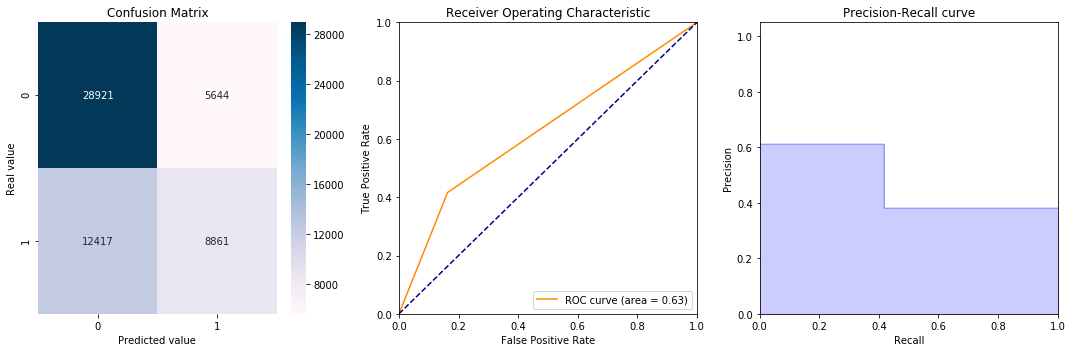

(0.676575398886163,
 array([0.38103254, 0.6108928 , 1.        ]),
 0.4952631137691082)

In [358]:
# predict for test dataset
w2v_pred=w2v_lr.predict(test_vecs)
# evaluate the classification result
plot_measurement(y_test, w2v_pred)